In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from prophet.diagnostics import performance_metrics
from prophet import Prophet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
D003_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D003_data.csv')
D003_df
D003_df['time'] =  pd.to_datetime(D003_df['time'], format='%Y-%m-%d %H:%M:%S')
D003_df.rename(columns = {'Rn':'y','time':'ds','T':'temperature','H':'humidity','P':'pressure','CO2':'co2',}, inplace = True)
D003_df = D003_df.reset_index(drop=True)
colList = list(D003_df.columns)
colList[1], colList[2] =  colList[2], colList[1]
D003_df = D003_df[colList]
D003_df
# D001_df.index = D001_df['time']
# D001_df = D001_df.drop(['time'],axis = 1)
# D001_df.index = D001_df.index.rename('ds')
# D001_df.rename(columns = {'Rn':'y'}, inplace = True)
# D001_columns = list(D001_df.columns)
# D001_columns[0],D001_columns[1] = D001_columns[1],D001_columns[0]
# D001_df = D001_df[D001_columns]

,ds,y,temperature,humidity,pressure,co2
0,2019-07-09 17:00:00,0.100000,33.463333,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,0.150000,33.490000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,0.161667,33.180000,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,3.451667,33.315000,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,11.556667,32.846667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
20019,2021-12-31 19:00:00,956.366667,28.650000,35.833333,102.174500,43.833333
20020,2021-12-31 20:00:00,1275.534000,28.758000,35.800000,102.192000,41.400000
20021,2021-12-31 21:00:00,1321.585000,28.730000,35.000000,102.246667,40.833333
20022,2021-12-31 22:00:00,1163.278333,28.530000,34.666667,102.356667,40.166667


In [21]:
D003_df

,ds,y,temperature,humidity,pressure,co2
0,2019-07-09 17:00:00,0.100000,33.463333,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,0.150000,33.490000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,0.161667,33.180000,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,3.451667,33.315000,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,11.556667,32.846667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
20019,2021-12-31 19:00:00,956.366667,28.650000,35.833333,102.174500,43.833333
20020,2021-12-31 20:00:00,1275.534000,28.758000,35.800000,102.192000,41.400000
20021,2021-12-31 21:00:00,1321.585000,28.730000,35.000000,102.246667,40.833333
20022,2021-12-31 22:00:00,1163.278333,28.530000,34.666667,102.356667,40.166667


In [35]:
d= D003_df.resample('H').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [22]:
training_data, testing_data = train_test_split(D003_df, test_size=0.2, shuffle=False)
testing_data = testing_data.reset_index(drop=True)

# testing_data_v2 = testing_data[['ds','T','H','P','CO2']]
# testing_data_v2 = testing_data.reset_index(drop=True)


# print(f"No. of training examples: {training_data.shape[0]}")
# print(f"No. of testing examples: {testing_data.shape[0]}")

In [23]:
training_data

,ds,y,temperature,humidity,pressure,co2
0,2019-07-09 17:00:00,0.100000,33.463333,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,0.150000,33.490000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,0.161667,33.180000,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,3.451667,33.315000,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,11.556667,32.846667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
16014,2021-07-15 04:00:00,444.861667,33.916667,30.000000,101.313000,32.333333
16015,2021-07-15 05:00:00,455.240000,33.580000,29.400000,101.327400,31.800000
16016,2021-07-15 06:00:00,454.936667,33.645000,29.500000,101.362500,31.666667
16017,2021-07-15 07:00:00,442.081667,33.781667,29.833333,101.390167,33.000000


In [24]:
testing_data

,ds,y,temperature,humidity,pressure,co2
0,2021-07-15 09:00:00,477.975000,34.195000,26.500000,101.388667,47.500000
1,2021-07-15 10:00:00,451.705000,34.661667,25.833333,101.374667,47.166667
2,2021-07-15 11:00:00,443.681667,34.713333,25.666667,101.360500,49.333333
3,2021-07-15 12:00:00,452.508000,35.198000,26.600000,101.333000,51.600000
4,2021-07-15 13:00:00,354.636000,35.420000,25.200000,101.298000,48.200000
...,...,...,...,...,...,...
4000,2021-12-31 19:00:00,956.366667,28.650000,35.833333,102.174500,43.833333
4001,2021-12-31 20:00:00,1275.534000,28.758000,35.800000,102.192000,41.400000
4002,2021-12-31 21:00:00,1321.585000,28.730000,35.000000,102.246667,40.833333
4003,2021-12-31 22:00:00,1163.278333,28.530000,34.666667,102.356667,40.166667


C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


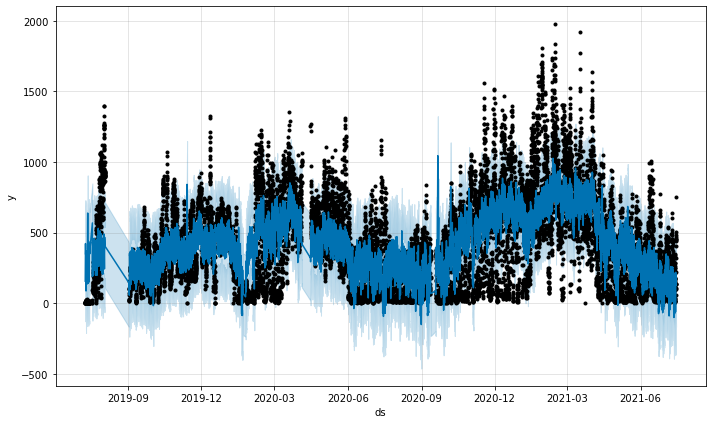

In [25]:
m = Prophet(changepoint_prior_scale=0.01)
m.add_regressor('temperature',standardize = False)
m.add_regressor('humidity',standardize = False)
m.add_regressor('pressure',standardize = False)
m.add_regressor('co2',standardize = False)
m.fit(training_data)

future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(training_data)
fig = m.plot(fcst)

In [26]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,co2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-09 17:00:00,-146.155479,-128.316454,457.144198,-146.155479,-146.155479,301.818233,301.818233,301.818233,22.924514,...,-19.954743,-19.954743,-19.954743,-166.935760,-166.935760,-166.935760,0.0,0.0,0.0,155.662753
1,2019-07-09 18:00:00,-146.155861,-90.024526,496.461587,-146.155861,-146.155861,345.119980,345.119980,345.119980,29.185411,...,-20.230691,-20.230691,-20.230691,-166.831297,-166.831297,-166.831297,0.0,0.0,0.0,198.964118
2,2019-07-09 19:00:00,-146.156243,-11.054249,580.424226,-146.156243,-146.156243,434.683850,434.683850,434.683850,29.281732,...,-20.520136,-20.520136,-20.520136,-166.725138,-166.725138,-166.725138,0.0,0.0,0.0,288.527607
3,2019-07-09 20:00:00,-146.156625,77.098129,688.769441,-146.156625,-146.156625,514.395312,514.395312,514.395312,31.111841,...,-20.815943,-20.815943,-20.815943,-166.617283,-166.617283,-166.617283,0.0,0.0,0.0,368.238687
4,2019-07-09 21:00:00,-146.157007,122.128403,705.270037,-146.157007,-146.157007,556.535282,556.535282,556.535282,30.630233,...,-21.110394,-21.110394,-21.110394,-166.507732,-166.507732,-166.507732,0.0,0.0,0.0,410.378275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16014,2021-07-15 04:00:00,-248.263213,-148.711039,436.253406,-248.263213,-248.263213,397.202766,397.202766,397.202766,18.686369,...,4.007775,4.007775,4.007775,-136.128054,-136.128054,-136.128054,0.0,0.0,0.0,148.939553
16015,2021-07-15 05:00:00,-248.328890,-180.857698,425.997575,-248.328890,-248.328890,385.352900,385.352900,385.352900,18.378140,...,5.879495,5.879495,5.879495,-135.818290,-135.818290,-135.818290,0.0,0.0,0.0,137.024010
16016,2021-07-15 06:00:00,-248.394567,-139.827396,432.575379,-248.394567,-248.394567,395.308721,395.308721,395.308721,18.301083,...,7.730404,7.730404,7.730404,-135.507589,-135.507589,-135.507589,0.0,0.0,0.0,146.914154
16017,2021-07-15 07:00:00,-248.460245,-144.873027,447.950728,-248.460245,-248.460245,406.967469,406.967469,406.967469,19.071655,...,9.547879,9.547879,9.547879,-135.195961,-135.195961,-135.195961,0.0,0.0,0.0,158.507224


In [30]:
testing_data.iloc[0]

ds             2021-07-15 09:00:00
y                          477.975
temperature                 34.195
humidity                      26.5
pressure                101.388667
co2                           47.5
Name: 0, dtype: object

In [31]:
a = m.predict(testing_data.iloc[0])

AttributeError: 'numpy.float64' object has no attribute 'values'

<h3>-----------------------------------------</h3>

In [132]:
model = Prophet()
model.add_regressor('temperature',standardize = False)
model.add_regressor('humidity',standardize = False)
model.add_regressor('pressure',standardize = False)
model.add_regressor('co2',standardize = False)

In [133]:
model.fit(training_data)

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [134]:
future = model.make_future_dataframe(periods=300, freq='H')
future['temperature'] = training_data['temperature']
future['humidity'] = training_data['humidity']
future['pressure'] = training_data['pressure'] 
future['co2'] = training_data['co2']

In [135]:
future

,ds
0,2019-07-09 17:00:00
1,2019-07-09 18:00:00
2,2019-07-09 19:00:00
3,2019-07-09 20:00:00
4,2019-07-09 21:00:00
...,...
16312,2021-07-27 16:00:00
16313,2021-07-27 17:00:00
16314,2021-07-27 18:00:00
16315,2021-07-27 19:00:00


In [136]:
fcst = model.predict(future)
fig = model.plot(fcst)
model.predict()

ValueError: Regressor 'temperature' missing from dataframe

In [54]:
model.params

{'k': array([[-0.00341073]]),
 'm': array([[-0.07383995]]),
 'delta': array([[-1.34329978e-01, -8.12809671e-02, -1.84404020e-02,
          6.54776011e-03,  6.20481357e-05,  2.31050160e-02,
          1.61021726e-01,  1.98618392e-01,  1.16836194e-01,
          8.62756130e-04, -7.48562233e-06, -1.99850084e-05,
          5.36997051e-03, -1.17264439e-02, -4.42002082e-03,
         -3.10140099e-04,  3.46645419e-04, -3.81754462e-03,
          1.68280669e-02,  1.64776816e-02, -5.14416796e-02,
         -1.40057470e-01, -2.59785477e-01, -2.59455578e-01,
         -1.64182176e-01]]),
 'sigma_obs': array([[0.11605517]]),
 'beta': array([[ 6.41085959e-02,  6.21192937e-02, -1.22411510e-03,
         -1.07401412e-02, -2.67831399e-02, -1.42329058e-02,
         -1.26143139e-02,  2.21625169e-03, -6.58484172e-03,
          1.19217959e-02,  6.47523526e-03, -3.08808896e-03,
         -1.21115098e-02,  3.01329489e-03, -4.21003636e-03,
         -2.38948221e-06,  2.11632958e-02,  1.60873072e-02,
          9.42281

In [55]:
testing_data_v2 = testing_data[['ds','temperature','humidity','pressure','co2']]
testing_data_v2

,ds,temperature,humidity,pressure,co2
0,2021-07-15 09:00:00,34.195000,26.500000,101.388667,47.500000
1,2021-07-15 10:00:00,34.661667,25.833333,101.374667,47.166667
2,2021-07-15 11:00:00,34.713333,25.666667,101.360500,49.333333
3,2021-07-15 12:00:00,35.198000,26.600000,101.333000,51.600000
4,2021-07-15 13:00:00,35.420000,25.200000,101.298000,48.200000
...,...,...,...,...,...
4000,2021-12-31 19:00:00,28.650000,35.833333,102.174500,43.833333
4001,2021-12-31 20:00:00,28.758000,35.800000,102.192000,41.400000
4002,2021-12-31 21:00:00,28.730000,35.000000,102.246667,40.833333
4003,2021-12-31 22:00:00,28.530000,34.666667,102.356667,40.166667


In [56]:
forecast = model.predict(testing_data_v2,fre)
forecast = forecast[['ds','yhat']]
forecast

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat
0,2021-07-15 09:00:00,62.197882
1,2021-07-15 10:00:00,-0.553527
2,2021-07-15 11:00:00,-35.008369
3,2021-07-15 12:00:00,-25.456461
4,2021-07-15 13:00:00,-31.226283
...,...,...
4000,2021-12-31 19:00:00,237.568217
4001,2021-12-31 20:00:00,295.570938
4002,2021-12-31 21:00:00,316.327852
4003,2021-12-31 22:00:00,315.116228


In [57]:
comparation_df = pd.concat((pd.DataFrame(forecast['yhat']),testing_data),axis = 1)

In [58]:
comparation_df 

,yhat,ds,y,temperature,humidity,pressure,co2
0,62.197882,2021-07-15 09:00:00,477.975000,34.195000,26.500000,101.388667,47.500000
1,-0.553527,2021-07-15 10:00:00,451.705000,34.661667,25.833333,101.374667,47.166667
2,-35.008369,2021-07-15 11:00:00,443.681667,34.713333,25.666667,101.360500,49.333333
3,-25.456461,2021-07-15 12:00:00,452.508000,35.198000,26.600000,101.333000,51.600000
4,-31.226283,2021-07-15 13:00:00,354.636000,35.420000,25.200000,101.298000,48.200000
...,...,...,...,...,...,...,...
4000,237.568217,2021-12-31 19:00:00,956.366667,28.650000,35.833333,102.174500,43.833333
4001,295.570938,2021-12-31 20:00:00,1275.534000,28.758000,35.800000,102.192000,41.400000
4002,316.327852,2021-12-31 21:00:00,1321.585000,28.730000,35.000000,102.246667,40.833333
4003,315.116228,2021-12-31 22:00:00,1163.278333,28.530000,34.666667,102.356667,40.166667


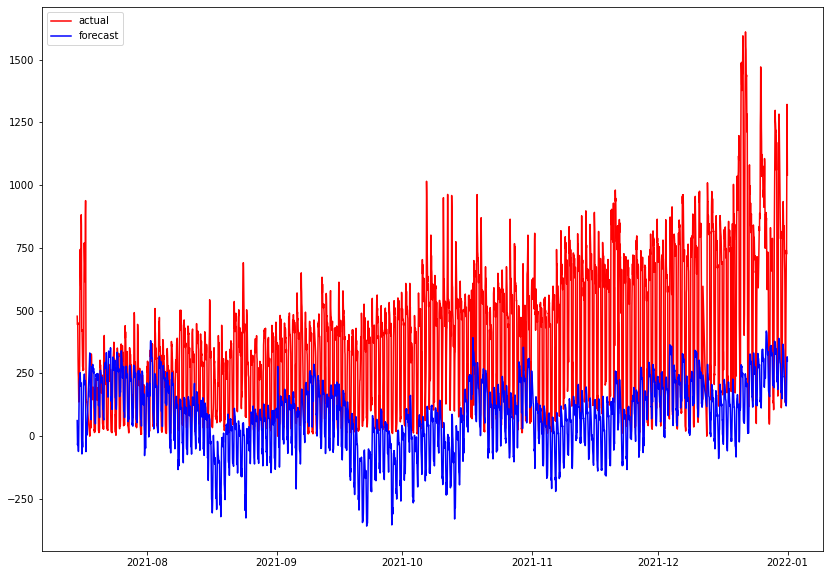

In [59]:
plt.figure(figsize=(14,10))
plt.plot(comparation_df['ds'],comparation_df['y'],color = 'red',label = 'actual')
plt.plot(comparation_df['ds'],comparation_df['yhat'],color = 'blue',label = 'forecast')
plt.legend()